In [73]:
import os
import mmcv
from mmcv import Config

from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import single_gpu_test

from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel

import pandas as pd
import numpy as np
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

# Ensemble
## define function get logit values (for mmsegmentation)

In [104]:
def get_model_logit(config_path, model_path):

    cfg = Config.fromfile(config_path)
    root = 'images/test/'

    cfg.data.test.img_dir = root
    cfg.data.test.pipeline[1]['img_scale'] = (512,512)
    cfg.data.test.test_mode = True


    cfg.work_dir = '/opt/ml/lab/mmsegmentation/work_dirs'

    cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
    cfg.model.train_cfg = None

    #define dataset
    dataset = build_dataset(cfg.data.test)
    data_loader = build_dataloader(
            dataset,
            samples_per_gpu=1,
            workers_per_gpu=cfg.data.workers_per_gpu,
            dist=False,
            shuffle=False)

    # build model architecture
    model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))
    checkpoint = load_checkpoint(model, model_path, map_location='cpu')
    
    model.CLASSES = dataset.CLASSES
    
    result = []
    
    for i in data_loader:
        result.append(model.inference(img=i['img'][0], img_meta=i['img_metas'][0].data[0], rescale=True))
    
    print(f'{model_path} is ready to run')
    return result

### get results from mmsegmentation models

In [78]:
model_path = '/opt/ml/lab/mmsegmentation/pretrained/'

output_1 = get_model_logit('/opt/ml/lab/config_file/upernet_swin.py', model_path+'swin_pseudo2_Fold_4.pth')
output_2 = get_model_logit('/opt/ml/lab/deeplabv3_p2p/my_deeplabv3plus_config.py', model_path+'deeplab_v3_vanila.pth')
output_3 = get_model_logit('/opt/ml/lab/1.ocrnet_hr_config/ocrnet_hr48_512x512_160k_ade20k.py', model_path+'hrnet_best_mIoU_epoch_2.pth')

2021-11-04 09:11:54,772 - mmseg - INFO - Loaded 819 images
/opt/ml/lab/mmsegmentation/mmseg/models/backbones/swin.py:553: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '


Use load_from_local loader
/opt/ml/lab/mmsegmentation/pretrained/swin_pseudo2_Fold_4.pth is ready to run
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 819/819, 5.5 task/s, elapsed: 148s, ETA:     0s

2021-11-04 09:14:25,765 - mmseg - INFO - Loaded 819 images


Use load_from_local loader
/opt/ml/lab/mmsegmentation/pretrained/deeplab_v3_vanila.pth is ready to run
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 819/819, 5.8 task/s, elapsed: 141s, ETA:     0s

2021-11-04 09:16:49,041 - mmseg - INFO - Loaded 819 images


Use load_from_local loader
/opt/ml/lab/mmsegmentation/pretrained/hrnet_best_mIoU_epoch_2.pth is ready to run
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 819/819, 5.8 task/s, elapsed: 141s, ETA:     0s

## for Segmentation Models Pytorch

### env set

In [28]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import json
import albumentations as A

import cv2
from torch.utils.data import DataLoader, Dataset

#preprocessing
from pycocotools.coco import COCO

random_seed = 15
random.seed(random_seed)
np.random.seed(random_seed)

### define dataset, dataloader

In [14]:
dataset_path = '/opt/ml/segmentation/input/data'
class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

In [15]:
from albumentations.pytorch import ToTensorV2

def collate_fn(batch):
    return tuple(zip(*batch))

transform = A.Compose([
    ToTensorV2()
])

test_path = '/opt/ml/segmentation/input/data/test.json'

test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=transform)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=4 , collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


### get output from models

In [ ]:
model = torch.load('/opt/ml/epoch17_plus.pth')
model.eval()

# get logit values for soft votting
smp_results = []
with torch.no_grad():
    for image, _ in tqdm(test_dataloader):
        output = model(torch.stack(image))
        output = F.softmax(output.squeeze(dim=0))
        smp_results.append(output)

### visualize for smp models

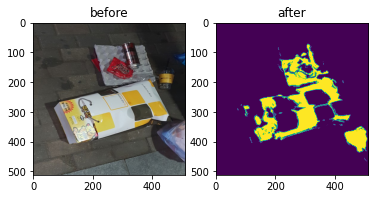

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [8 0 0 ... 0 0 0]]
0 228179
2 5
8 33960
None


In [72]:
smp_img_num = 119
fig, ax = plt.subplots(nrows=1, ncols=2)

img = cv2.imread(f'/opt/ml/lab/mmsegmentation/fold_dataset/images/test/{smp_img_num:04}.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ax[0].set_title('before')
ax[1].set_title('after')

ax[0].imshow(img)
ax[1].imshow(smp_results[smp_img_num])

plt.show()

print(smp_results[smp_img_num])
print(cal_class_counts(smp_results[smp_img_num]))

### visualize for mmsegmentation models
- result = sum(output_1, output_2)
- argmax(result, axis=0)

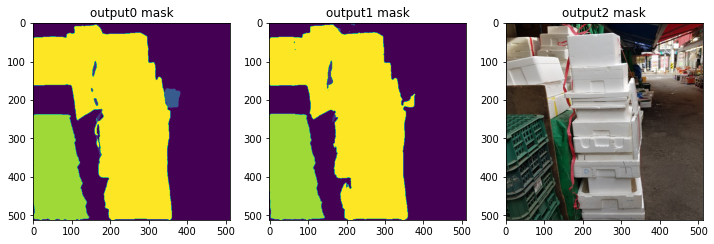

In [95]:
img_num = 245
img = cv2.imread(f'/opt/ml/lab/mmsegmentation/fold_dataset/images/test/{img_num:04}.jpg')
# print(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# mask = np.where(mask==0, 255, mask)

predict_mask_array = []

predict_mask_array.append(output_1[img_num].argmax(axis=0))
predict_mask_array.append(output_2[img_num].argmax(axis=0))
# predict_mask_array.append(output_3[img_num].argmax(axis=0))
# predict_mask_array.append(output_4[img_num].argmax(axis=0))
# predict_mask_array.append(output_5[img_num].argmax(axis=0))
predict_mask_array.append(img)

fig, ax = plt.subplots(nrows=1, ncols=len(predict_mask_array), figsize=(12, 12))

for i in range(len(predict_mask_array)):
    ax[i].set_title(f'output{i} mask')
    ax[i].imshow(predict_mask_array[i])

plt.show()

In [56]:
def cal_class_counts(value):
    classes, counts = np.unique(value, return_counts=True)
    for i,v in zip(classes, counts):
        print(i,v)
        
# for item in predict_mask_array:
#     cal_class_counts(item)

## Ensemble results

In [90]:
output_to_mask = []

for item_1, item_2 in tqdm(zip(output_1, output_2)):
    
    new_item = item_1 + item_2
    output_to_mask.append(new_item.argmax(axis=0))

819it [00:08, 97.41it/s] 


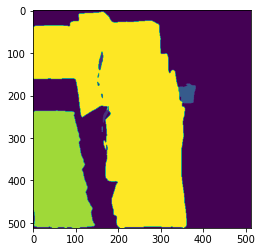

In [96]:
# preview ensemble images
plt.imshow(output_to_mask[img_num])
classes, counts = np.unique(output_to_mask[img_num], return_counts=True)

In [52]:
cal_class_counts(output_to_mask[img_num])

0 189937
2 72196
6 11


In [97]:
# sample_submisson.csv 열기
submission = pd.read_csv('/opt/ml/segmentation/baseline_code/submission/sample_submission.csv', index_col=None)
json_dir = os.path.join("/opt/ml/segmentation/input/data/test.json") # original json file
save_dir = '/opt/ml/lab/config_file/work_dirs/upernet_swin'
with open(json_dir, "r", encoding="utf8") as outfile:
    datas = json.load(outfile)

input_size = 512
output_size = 256
bin_size = input_size // output_size

# PredictionString 대입
for image_id, predict in enumerate(output_to_mask):
    image_id = datas["images"][image_id]
    file_name = image_id["file_name"]
    
    temp_mask = []
    predict = predict.reshape(1, 512, 512)
    mask = predict.reshape((1, output_size, bin_size, output_size, bin_size)).max(4).max(2) # resize to 256*256
    temp_mask.append(mask)
    oms = np.array(temp_mask)
    oms = oms.reshape([oms.shape[0], output_size*output_size]).astype(int)

    string = oms.flatten()

    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv(os.path.join(save_dir, f'submission_final_ensemble.csv'), index=False)

### save ensemble logit values

In [25]:
import pickle

pickle_list = []

for item_1, item_2, item_3, item_4, item_5 in tqdm(zip(output_1, output_2, output_3, output_4, output_5)):
    
    new_item = item_1 + item_2 + item_3 + item_4 + item_5
    pickle_list.append(new_item)
    
with open('swin_fold_ensemble.bin', 'wb') as f:
    pickle.dump(pickle_list , f)

819it [00:28, 29.10it/s]


In [26]:
with open('swin_fold_ensemble.bin' ,'rb') as ff:
    data = pickle.load(ff)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [30]:
print(np.array(data).shape)

(819, 11, 512, 512)
